In [41]:
import os, random, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torchsort

import matplotlib.pyplot as plt

In [42]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE =", DEVICE)

MODEL_NAME = "bert-base-multilingual-cased"
DATASET_NAME = "MonoHime/ru_sentiment_dataset"

TEXT_COL = "text"
LABEL_COL = "sentiment"

MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 3
LR = 2e-4

MAX_TRAIN = 8000
MAX_VALID = 2000
MAX_TEST = 3000

DEVICE = cuda


In [43]:
from datasets import ClassLabel

ds = load_dataset(DATASET_NAME)
print(ds)

# validation будем использовать как test
assert "train" in ds, "Нет сплита train"
test_split_name = "validation" if "validation" in ds else None
assert test_split_name is not None, "Нет validation"

# Собираем mapping меток в 0..K-1
label_values = sorted(set(ds["train"][LABEL_COL]))
value_to_id = {v: i for i, v in enumerate(label_values)}
id_to_value = {i: v for v, i in value_to_id.items()}
num_classes = len(label_values)
print("Labels:", label_values, "num_classes =", num_classes)


def encode_labels(example):
    example["labels"] = int(value_to_id[example[LABEL_COL]])
    return example


ds = ds.map(encode_labels)
ds = ds.cast_column("labels", ClassLabel(num_classes=num_classes, names=[str(x) for x in label_values]))

split = ds["train"].train_test_split(test_size=0.2, seed=SEED, stratify_by_column="labels")
train_full = split["train"]
valid_full = split["test"]
test_full = ds[test_split_name]  # используем validation как test

print("train_full:", len(train_full), "valid_full:", len(valid_full), "test_full:", len(test_full))


# Подвыборка для скорости
def maybe_subsample(hfds, max_n, seed=SEED):
    if max_n is None or len(hfds) <= max_n:
        return hfds
    hfds = hfds.shuffle(seed=seed)
    return hfds.select(range(max_n))


train_ds = maybe_subsample(train_full, MAX_TRAIN)
valid_ds = maybe_subsample(valid_full, MAX_VALID)
test_ds = maybe_subsample(test_full, MAX_TEST)

print("Subsampled sizes:", len(train_ds), len(valid_ds), len(test_ds))

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})
Labels: [0, 1, 2] num_classes = 3
train_full: 151912 valid_full: 37979 test_full: 21098
Subsampled sizes: 8000 2000 3000


In [44]:
def make_loader(hf_ds, batch_size=32, shuffle=False):
    def collate(batch):
        texts = [x[TEXT_COL] for x in batch]
        labels = torch.tensor([int(x["labels"]) for x in batch], dtype=torch.long)
        return texts, labels

    return DataLoader(hf_ds, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)


train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = make_loader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

texts, y = next(iter(train_loader))
print("Batch check:", type(texts), len(texts), "labels shape:", y.shape, "labels example:", y[:5].tolist())

Batch check: <class 'list'> 32 labels shape: torch.Size([32]) labels example: [1, 0, 0, 1, 1]


In [45]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
backbone = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()

# Замораживаем backbone
for p in backbone.parameters():
    p.requires_grad_(False)


class Head(nn.Module):
    def __init__(self, in_dim=768, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


head = Head(in_dim=768, num_classes=num_classes).to(DEVICE)

In [46]:
@torch.no_grad()
def encode_batch(texts):
    batch = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    ).to(DEVICE)

    out = backbone(**batch)
    # CLS embedding: last_hidden_state[:,0,:]
    x = out.last_hidden_state[:, 0, :]
    return x  # [B,768]

In [47]:
def ndcg_topk_surrogate(logits: torch.Tensor, y: torch.Tensor, k: int = 5, tau: float = 1.0):
    """
    Дифференцируемый surrogate для NDCG@k в мультиклассовой классификации:
    релевантность = 1 только у истинного класса, 0 у остальных.
    """
    ranks = torchsort.soft_rank(-logits, regularization_strength=tau)  # -logits: больший logit -> меньший ранг
    r_true = ranks[torch.arange(logits.size(0), device=logits.device), y]  # [B]

    # мягкое попадание в top-k
    gate = torch.sigmoid((k + 0.5 - r_true) / tau)  # ~1 если r_true<=k
    ndcg = gate / torch.log2(r_true + 1.0)  # ideal=1 при rank=1
    return ndcg.mean()


def loss_ce_plus_ndcg(logits, y, k=5, tau=1.0, lam=0.5):
    ce = F.cross_entropy(logits, y)
    ndcg = ndcg_topk_surrogate(logits, y, k=k, tau=tau)
    loss = ce + lam * (1.0 - ndcg)
    return loss, ce.detach(), ndcg.detach()

In [48]:
from sklearn.metrics import accuracy_score, f1_score


def eval_metrics(logits_np, y_np, k_list=(1, 3, 5)):
    y_pred = logits_np.argmax(axis=1)
    acc = accuracy_score(y_np, y_pred)
    f1m = f1_score(y_np, y_pred, average="macro")

    # hit@k (top-k accuracy)
    hit = {}
    for k in k_list:
        topk = np.argpartition(-logits_np, kth=k - 1, axis=1)[:, :k]
        hit[f"hit@{k}"] = float((topk == y_np[:, None]).any(axis=1).mean())

    # NDCG@k для 1 релевантного класса: DCG=1/log2(rank+1) если rank<=k, иначе 0
    ndcg = {}
    ranks = (-logits_np).argsort(axis=1).argsort(axis=1) + 1  # 1..C
    r_true = ranks[np.arange(len(y_np)), y_np]
    for k in k_list:
        val = np.where(r_true <= k, 1.0 / np.log2(r_true + 1.0), 0.0).mean()
        ndcg[f"ndcg@{k}"] = float(val)

    return {"acc": float(acc), "f1_macro": float(f1m), **hit, **ndcg}


@torch.no_grad()
def evaluate(head_model, loader, k_list=(1, 3, 5)):
    head_model.eval()
    logits_all, y_all = [], []
    for texts, y in loader:
        y = y.to(DEVICE)
        x = encode_batch(texts)
        logits = head_model(x)
        logits_all.append(logits.detach().cpu().numpy())
        y_all.append(y.detach().cpu().numpy())
    logits_np = np.concatenate(logits_all, axis=0)
    y_np = np.concatenate(y_all, axis=0)
    return eval_metrics(logits_np, y_np, k_list=k_list)

In [49]:
def train(head_model, train_loader, valid_loader, epochs=3, lr=2e-4,
          use_ndcg=False, lam=0.5, k=3, tau=1.0):
    head_model.to(DEVICE)
    opt = torch.optim.AdamW(head_model.parameters(), lr=lr)

    history = []
    for ep in range(1, epochs + 1):
        head_model.train()
        running = 0.0

        for texts, y in train_loader:
            y = y.to(DEVICE)
            x = encode_batch(texts)
            logits = head_model(x)

            if use_ndcg:
                loss, ce, ndcg = loss_ce_plus_ndcg(logits, y, k=k, tau=tau, lam=lam)
            else:
                loss = F.cross_entropy(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item()

        metrics = evaluate(head_model, valid_loader, k_list=(1, 3))  # Changed (1,3,5) to (1,3)
        row = {
            "epoch": ep,
            "train_loss": running / max(1, len(train_loader)),
            **metrics
        }
        history.append(row)
        print(f"[ep {ep}] loss={row['train_loss']:.4f} acc={row['acc']:.4f} f1m={row['f1_macro']:.4f} "
              f"hit@1={row['hit@1']:.4f} hit@3={row['hit@3']:.4f} "  # Removed hit@5 from print
              f"ndcg@3={row['ndcg@3']:.4f}")
    return pd.DataFrame(history)


# Baseline: CE
head_ce = Head(768, num_classes)
hist_ce = train(head_ce, train_loader, valid_loader, epochs=EPOCHS, lr=LR, use_ndcg=False)

# CE + NeuralNDCG-style
head_ndcg = Head(768, num_classes)
hist_ndcg = train(head_ndcg, train_loader, valid_loader, epochs=EPOCHS, lr=LR,
                  use_ndcg=True, lam=0.5, k=3, tau=1.0)

[ep 1] loss=0.9616 acc=0.5530 f1m=0.4901 hit@1=0.5530 hit@3=1.0000 ndcg@3=0.8217
[ep 2] loss=0.8648 acc=0.5530 f1m=0.5016 hit@1=0.5530 hit@3=1.0000 ndcg@3=0.8198
[ep 3] loss=0.8276 acc=0.5915 f1m=0.5178 hit@1=0.5915 hit@3=1.0000 ndcg@3=0.8349
[ep 1] loss=1.1552 acc=0.5155 f1m=0.3384 hit@1=0.5155 hit@3=1.0000 ndcg@3=0.8050
[ep 2] loss=1.0302 acc=0.5885 f1m=0.5460 hit@1=0.5885 hit@3=1.0000 ndcg@3=0.8360
[ep 3] loss=0.9831 acc=0.6120 f1m=0.6032 hit@1=0.6120 hit@3=1.0000 ndcg@3=0.8450


- Hit@1 в многоклассовой классификации — это по сути Accuracy (правильный класс на 1-м месте).
- Macro-F1 — среднее F1 по классам. Оно особенно важно при дисбалансе: если один класс доминирует, Accuracy может почти не меняться, а Macro-F1 покажет улучшение качества на редких классах.
- Hit@k — доля примеров, где истинный класс попал в top-k по логитам.
- NDCG@k — более “тонкая” метрика, чем Hit@k: она учитывает не только попадание в top-k, но и позицию истинного класса внутри ранжирования (раньше = лучше, потому что есть логарифмический дисконт).

У меня 3 класса, k=3, поэтому Hit@3 всегда равен 1.0 (истинный класс неизбежно внутри top-3, потому что top-3 = все классы).
Hit@3 тут неинформативна.

Однако NDCG@3 всё ещё информативна, потому что даже при k=3 она показывает, как часто истинный класс стоит на 1-м месте vs 2-м vs 3-м:
- rank=1 → вклад 1 / log2(2) = 1.0
- rank=2 → вклад 1 / log2(3) ≈ 0.631
- rank=3 → вклад 1 / log2(4) = 0.5

То есть рост NDCG@3 означает, что модель чаще ставит правильный класс выше (ближе к рангу 1).

In [50]:
test_ce = evaluate(head_ce, test_loader, k_list=(1, 3))
test_ndcg = evaluate(head_ndcg, test_loader, k_list=(1, 3))

df_results = pd.DataFrame([
    {"model": "CE baseline", **test_ce},
    {"model": "CE + NeuralNDCG-style", **test_ndcg},
])

print("=== TEST results ===")
display(df_results)

=== TEST results ===


,model,acc,f1_macro,hit@1,hit@3,ndcg@1,ndcg@3
0,CE baseline,0.584333,0.505141,0.584333,1.0,0.584333,0.830747
1,CE + NeuralNDCG-style,0.584000,0.573090,0.584000,1.0,0.584000,0.833548


- Accuracy / Hit@1 почти одинаковые
- CE baseline: acc ≈ 0.5843
- CE + NeuralNDCG-style: acc ≈ 0.5840

Это означает: по грубому показателю (сколько раз угадали top-1) методы близки.

- Macro-F1 заметно лучше у NeuralNDCG-style
- CE baseline: Macro-F1 ≈ 0.505
- CE + NeuralNDCG-style: Macro-F1 ≈ 0.573  (существенный прирост)

Это ключевой сигнал, что NeuralNDCG-style улучшила качество именно по классам в среднем.

- NDCG@3 чуть выше у NeuralNDCG-style
- baseline: ndcg@3 ≈ 0.8307
- ndcg-style: ndcg@3 ≈ 0.8335

Разница небольшая, но согласуется с идеей: модель чуть лучше расставляет приоритеты (правильный класс в среднем выше по рангу).

При этом Hit@3 на TEST = 1.0 у обоих (по той же причине: 3 класса).

Практическая интерпретация: NeuralNDCG-style почти не меняет угадал/не угадал top-1 в среднем (accuracy), но делает предсказания более сбалансированными по классам (Macro-F1 ↑), и слегка улучшает качество ранжирования внутри top-3 (NDCG@3 ↑).

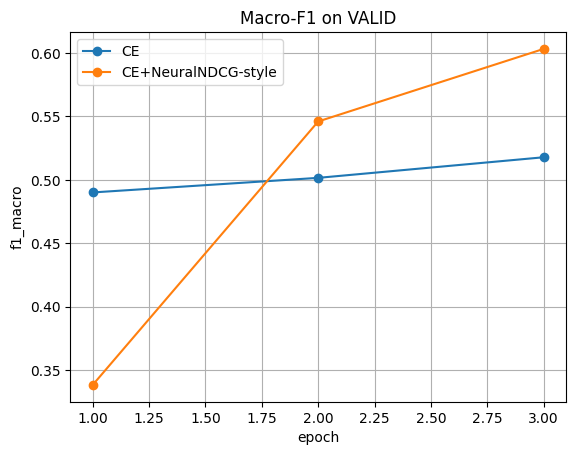

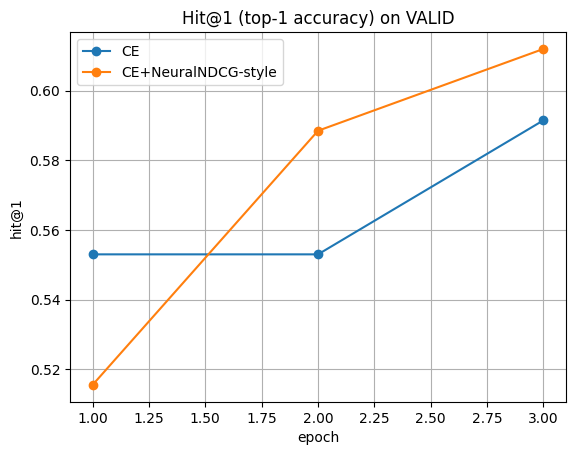

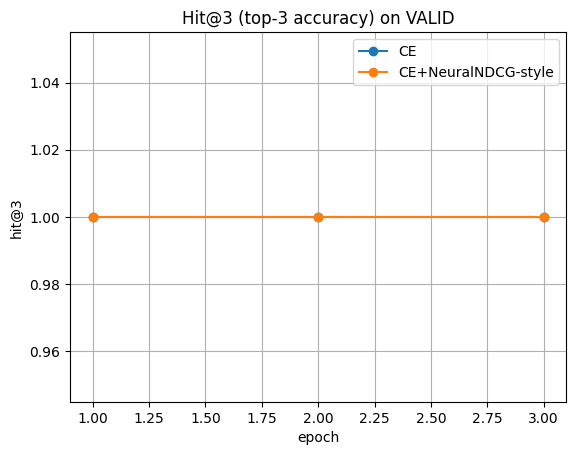

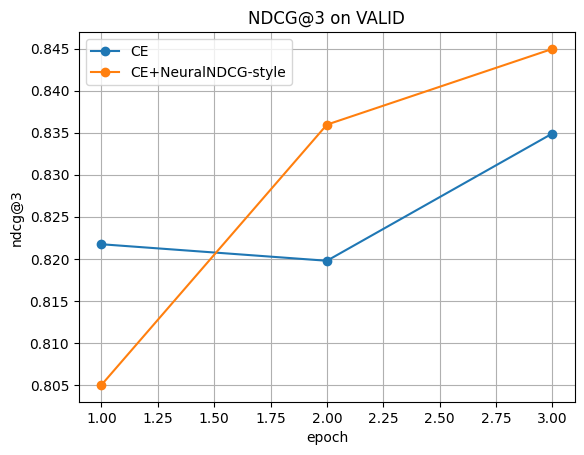

In [51]:
def plot_metric(hist_a, hist_b, col, title):
    plt.figure()
    plt.plot(hist_a["epoch"], hist_a[col], marker="o")
    plt.plot(hist_b["epoch"], hist_b[col], marker="o")
    plt.xlabel("epoch")
    plt.ylabel(col)
    plt.title(title)
    plt.legend(["CE", "CE+NeuralNDCG-style"])
    plt.grid(True)
    plt.show()


plot_metric(hist_ce, hist_ndcg, "f1_macro", "Macro-F1 on VALID")
plot_metric(hist_ce, hist_ndcg, "hit@1", "Hit@1 (top-1 accuracy) on VALID")
plot_metric(hist_ce, hist_ndcg, "hit@3", "Hit@3 (top-3 accuracy) on VALID")
plot_metric(hist_ce, hist_ndcg, "ndcg@3", "NDCG@3 on VALID")

## Анализ динамики на VALID по эпохам

По логам и графикам видно следующее:

### Baseline (CE)
- VALID accuracy/hit@1 растёт умеренно: примерно с ~0.553 до ~0.592 к 3-й эпохе.
- Macro-F1 растёт с ~0.49 до ~0.518.
- NDCG@3 колеблется и в итоге приходит к ~0.835.

CE хорошо оптимизирует среднюю классификационную ошибку и аккуратно улучшает качество, но не обязательно фокусируется на корректной позиции истинного класса в ранжировании логитов.

### CE + NeuralNDCG-style
- На 1-й эпохе качество хуже (и это ожидаемо): добавка к лоссу меняет оптимизацию, модель сначала переучивается под новую цель.
- Macro-F1 стартует низко (~0.34), но затем резко растёт.
- Уже к 2–3 эпохе видно преимущество:
- VALID hit@1/accuracy выше (к 3-й эпохе ~0.612 против ~0.592 у CE)
- VALID Macro-F1 выше (~0.603 против ~0.518)
- VALID NDCG@3 выше и растёт более устойчиво (до ~0.845)

Интерпретация: NeuralNDCG-style действительно подталкивает модель к тому, чтобы истинный класс поднимался выше в ранжировании (что видно по NDCG@3), и это приводит к улучшению как top-1 (hit@1), так и Macro-F1.

Hit@3 = 1.0 на всех эпохах — потому что при 3 классах top-3 включает все классы. Это ожидаемое поведение.

## Вывод

Добавление NeuralNDCG-style компоненты к Cross-Entropy практически не изменило общую accuracy на TEST, но заметно улучшило Macro-F1, что указывает на более сбалансированное качество по классам.
Top-k метрика Hit@3 оказалась неинформативной из-за 3 классов (всегда 1.0), однако рост NDCG@3 и улучшение Macro-F1 показывают, что модель лучше ранжирует истинный класс и повышает качество предсказаний на отдельных классах.